In [2]:
import sys
sys.path.append('../..')

import os
import shutil

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from seismicpro.batchflow import Pipeline, C, V, B, L, I, W

from seismicpro.src import FieldIndex, TraceIndex, CustomIndex, SeismicDataset, merge_segy_files


from Ground_Roll.src.utils import make_index, check_res, visualize_geom

In [2]:
paths = dict(raw = '/notebooks/data/H1_WZ/NA/arw_raw_DN00.sgy', lift = '/notebooks/data/H1_WZ/NA/arw_raw_DN03.sgy')

findex = make_index(paths, extra_headers='all')
fdf = findex.get_df()

Fields: 1140, bins: 59904


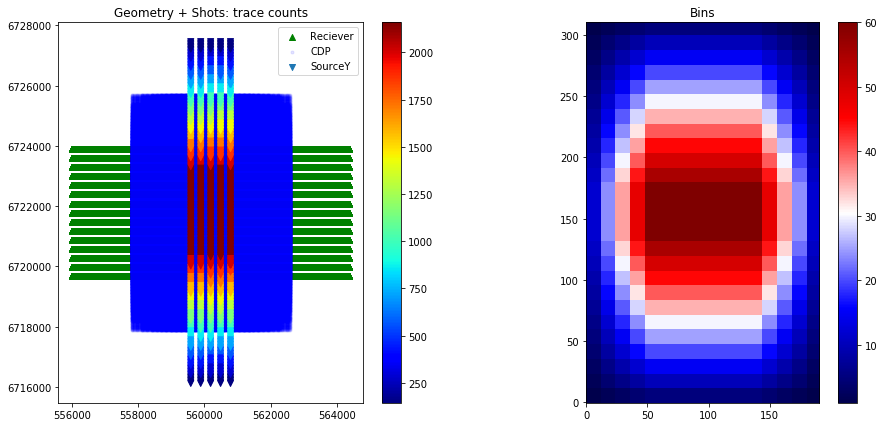

In [3]:
visualize_geom(fdf)

In [4]:
vc = fdf.CDP.value_counts()
bdf = fdf[fdf.CDP.isin(vc[vc >= 60].index)]

q20, q40, q60, q80 = bdf.CDP_Y.quantile(0.2), bdf.CDP_Y.quantile(0.4), bdf.CDP_Y.quantile(0.6), bdf.CDP_Y.quantile(0.8)

Fields: 360, bins: 768


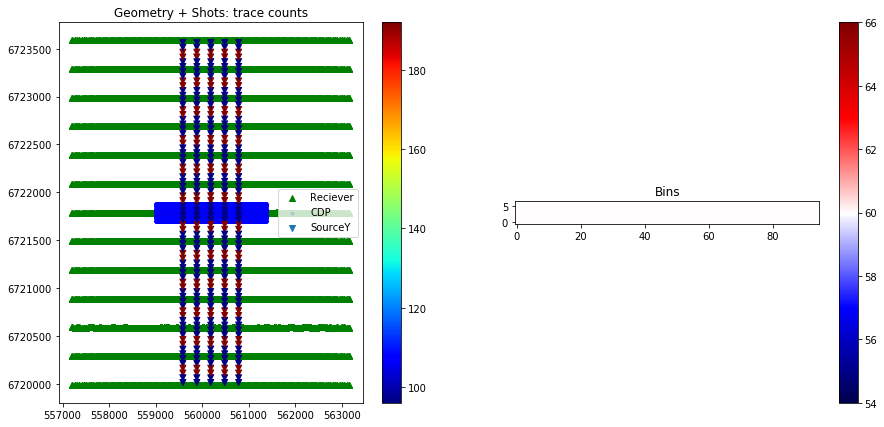

In [5]:
CDP_val = bdf[(bdf.CDP_Y > q40) & (bdf.CDP_Y < q60)]['CDP'].unique()

fdf_cdp_val = fdf[fdf.CDP.isin(CDP_val)]

visualize_geom(fdf_cdp_val)

In [6]:
q0, q100 = fdf.CDP_Y.quantile(0.15), fdf.CDP_Y.quantile(0.85)

Fields: 90, bins: 11520


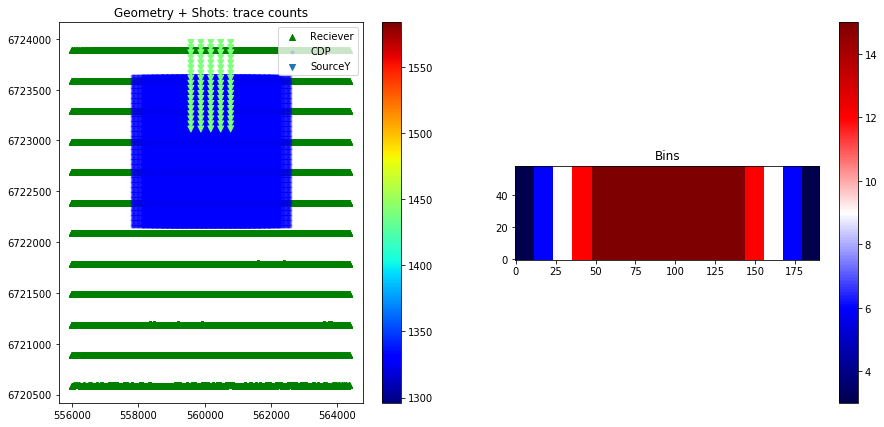

In [7]:
fdf_tr_1 = fdf[(fdf.CDP_Y >= q80) & (fdf.CDP_Y <= q100)]

vcf = fdf_tr_1.FieldRecord.value_counts()
fdf_tr_1 = fdf_tr_1[fdf_tr_1.FieldRecord.isin(vcf[vcf >= 1400].index)]

FR_tr_1 = fdf_tr_1.FieldRecord.unique()
CDP_tr_1 = fdf_tr_1.CDP.unique()

visualize_geom(fdf_tr_1)

Fields: 90, bins: 11520


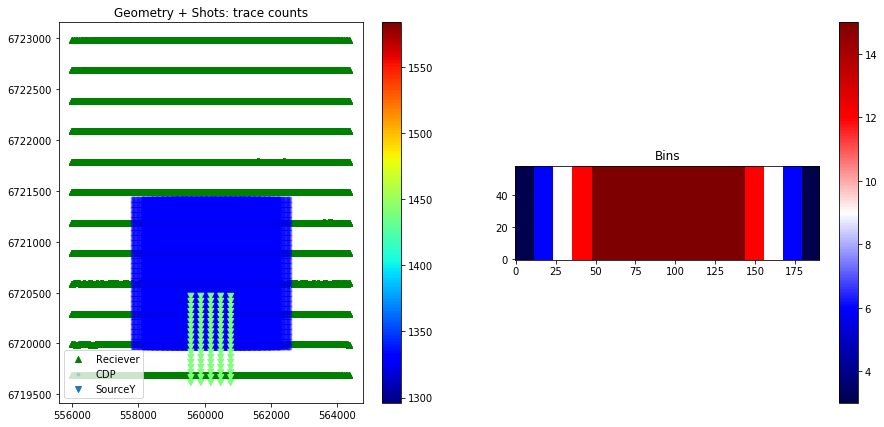

In [8]:
fdf_tr_2 = fdf[(fdf.CDP_Y >= q0) & (fdf.CDP_Y <= q20)]

vcf = fdf_tr_2.FieldRecord.value_counts()
fdf_tr_2 = fdf_tr_2[fdf_tr_2.FieldRecord.isin(vcf[vcf >= 1400].index)]

FR_tr_2 = fdf_tr_2.FieldRecord.unique()
CDP_tr_2 = fdf_tr_2.CDP.unique()

visualize_geom(fdf_tr_2)

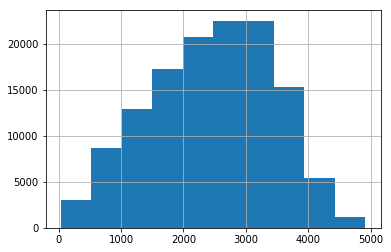

In [9]:
fdf_tr_2.offset.hist()

In [10]:
def dump_results(ds, comp, prefix, out_fld='data'):
    
    tmp_dump_path = 'tmp'
    if os.path.exists(tmp_dump_path):
        shutil.rmtree(tmp_dump_path)
    os.makedirs(tmp_dump_path)
    
    inference_pipeline = (ds.p
                          .load(components=comp, fmt='segy', tslice=np.arange(3000))
                          .sort_traces(src=comp, dst=comp, sort_by='offset')
                          .dump(path=L(lambda x: os.path.join(tmp_dump_path, str(x) + '.sgy'))(I()), src=comp, fmt='segy', split=False)
                         )

    inference_pipeline.run(4, n_epochs=1, drop_last=False, shuffle=False, bar=True)
    
    output_path = os.path.join(out_fld, prefix + '_' + comp + '.sgy')
    if not os.path.exists(out_fld):
        os.makedirs(out_fld)
    
    merge_segy_files(output_path=output_path, extra_headers='all', path=os.path.join(tmp_dump_path, '*.sgy'), bar=True)
    
    if os.path.exists(tmp_dump_path):
        shutil.rmtree(tmp_dump_path)

    return output_path

In [11]:
bi = CustomIndex(findex, index_name='CDP')

In [12]:
fi = FieldIndex(bi.create_subset(CDP_tr_1)).create_subset(FR_tr_1)
ds = SeismicDataset(fi)

for comp in ('raw', 'lift'):
    print(dump_results(ds, comp, 'FR_train_1'))

  0%|          | 0/23 [00:00<?, ?it/s]

data/FR_train_1_raw.sgy


100%|██████████| 23/23 [00:31<00:00,  1.36s/it]


data/FR_train_1_lift.sgy


In [13]:
fi = FieldIndex(bi.create_subset(CDP_tr_2)).create_subset(FR_tr_2)
ds = SeismicDataset(fi)

for comp in ('raw', 'lift'):
    print(dump_results(ds, comp, 'FR_train_2'))

  0%|          | 0/23 [00:00<?, ?it/s]

data/FR_train_2_raw.sgy


100%|██████████| 23/23 [00:34<00:00,  1.48s/it]


data/FR_train_2_lift.sgy


In [14]:
fi = FieldIndex(bi.create_subset(CDP_val))
ds = SeismicDataset(fi)

for comp in ('raw', 'lift'):
    print(dump_results(ds, comp, 'CDP_val'))

  0%|          | 0/90 [00:00<?, ?it/s]

data/CDP_val_raw.sgy


100%|██████████| 90/90 [00:11<00:00,  8.07it/s]


data/CDP_val_lift.sgy


In [15]:
!ls -lh data

total 7.0G
-rw-r--r-- 1 root root 538M Dec 26 13:18 CDP_val_lift.sgy
-rw-r--r-- 1 root root 538M Dec 26 13:17 CDP_val_raw.sgy
-rw-r--r-- 1 root root 1.5G Dec 26 13:12 FR_train_1_lift.sgy
-rw-r--r-- 1 root root 1.5G Dec 26 13:11 FR_train_1_raw.sgy
-rw-r--r-- 1 root root 1.5G Dec 26 13:15 FR_train_2_lift.sgy
-rw-r--r-- 1 root root 1.5G Dec 26 13:14 FR_train_2_raw.sgy


In [3]:
paths = dict(raw = 'data/FR_train_1_raw.sgy', lift = 'data/FR_train_1_lift.sgy')

findex = make_index(paths, extra_headers='all')

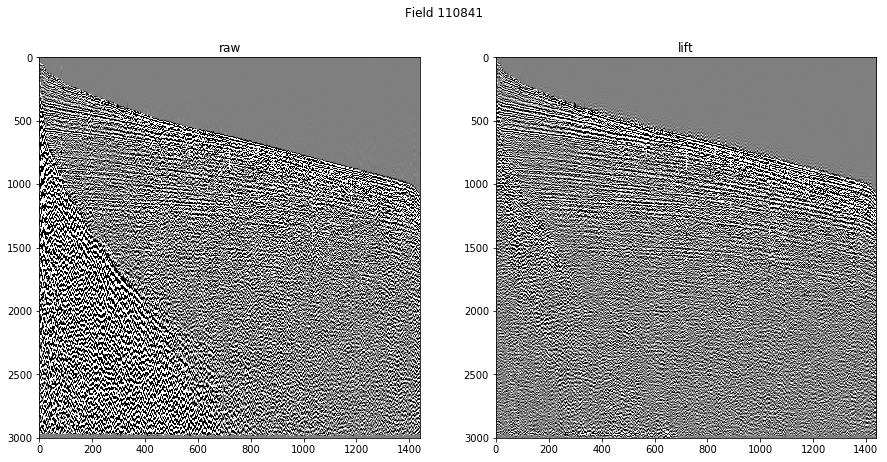

In [6]:
check_res(0, findex, ('raw', 'lift'), figsize=(15, 7));

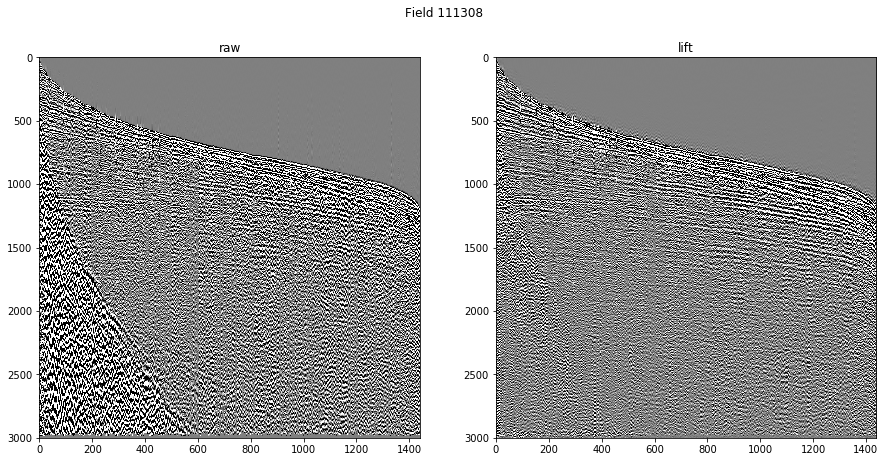

In [7]:
check_res(50, findex, ('raw', 'lift'), figsize=(15, 7));

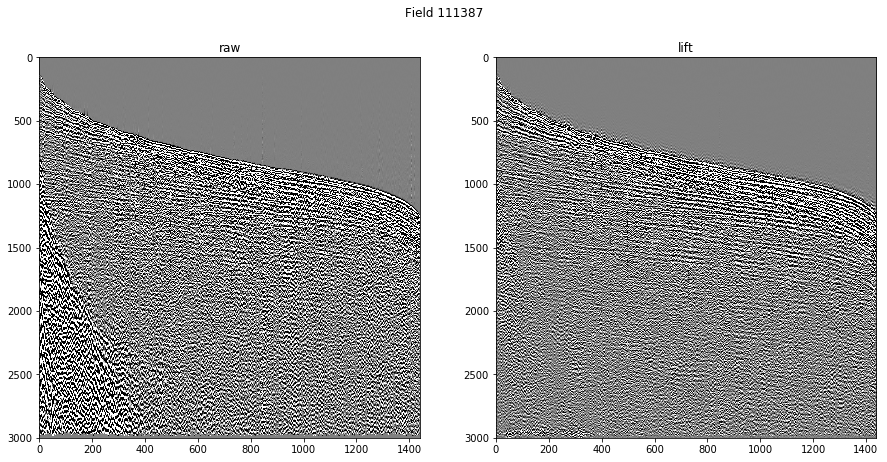

In [9]:
check_res(80, findex, ('raw', 'lift'), figsize=(15, 7));